<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#plot" data-toc-modified-id="plot-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>plot</a></span></li><li><span><a href="#compile-and-fit" data-toc-modified-id="compile-and-fit-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>compile and fit</a></span></li></ul></li><li><span><a href="#single-step-models" data-toc-modified-id="single-step-models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>single-step models</a></span><ul class="toc-item"><li><span><a href="#linear" data-toc-modified-id="linear-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>linear</a></span></li><li><span><a href="#Dense" data-toc-modified-id="Dense-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dense</a></span></li><li><span><a href="#CNN" data-toc-modified-id="CNN-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>CNN</a></span></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>LSTM</a></span></li></ul></li><li><span><a href="#multi-step-models" data-toc-modified-id="multi-step-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>multi-step models</a></span><ul class="toc-item"><li><span><a href="#linear" data-toc-modified-id="linear-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>linear</a></span></li><li><span><a href="#dense" data-toc-modified-id="dense-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>dense</a></span></li><li><span><a href="#CNN" data-toc-modified-id="CNN-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CNN</a></span></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>LSTM</a></span></li></ul></li></ul></div>

https://towardsdatascience.com/how-to-get-stock-data-using-python-c0de1df17e75

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import Counter
import matplotlib as mpl
import seaborn as sns
import numpy as np

label_size = 13
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size


In [2]:
import yfinance as yf

#define the ticker symbol
tickerSymbol = 'AAPL'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', 
                              start='2010-1-1', 
                              end='2021-7-25')

#see your data
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-12-31,6.535605,6.542351,6.456796,6.462008,352410800,0.0,0.0
2010-01-04,6.544805,6.577616,6.512607,6.562591,493729600,0.0,0.0
2010-01-05,6.580681,6.611040,6.539283,6.573935,601904800,0.0,0.0
2010-01-06,6.573936,6.600001,6.462623,6.469369,552160000,0.0,0.0
2010-01-07,6.493286,6.500952,6.410490,6.457407,477131200,0.0,0.0
...,...,...,...,...,...,...,...
2021-07-19,143.534951,143.854480,141.458061,142.236893,121434600,0.0,0.0
2021-07-20,143.245388,146.879942,142.746136,145.931351,96350000,0.0,0.0
2021-07-21,145.312290,145.911399,144.413643,145.182480,74993500,0.0,0.0


Text(0, 0.5, 'USD')

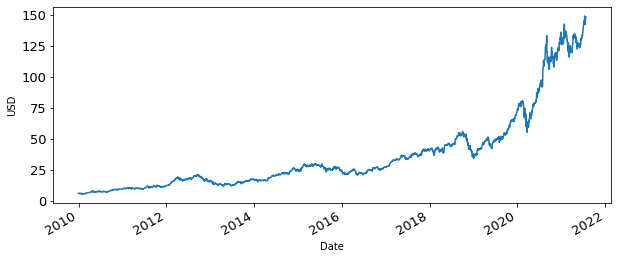

In [3]:
plt.figure(figsize=(10,4))
tickerDf['Close'].plot()
plt.ylabel("USD")

In [4]:
Counter(tickerData.recommendations['To Grade'])

Counter({'Buy': 311,
         'Outperform': 158,
         'Overweight': 128,
         'Sector Perform': 4,
         'Neutral': 81,
         'Sector Outperform': 2,
         'Hold': 39,
         'Market Perform': 24,
         '': 3,
         'Strong Buy': 8,
         'Long-term Buy': 1,
         'Sell': 8,
         'Market Outperform': 3,
         'Positive': 4,
         'Long-Term Buy': 1,
         'Equal-weight': 1,
         'Equal-Weight': 20,
         'Perform': 2,
         'Negative': 1,
         'Reduce': 1,
         'Underweight': 1,
         'Underperform': 1,
         'Sector Weight': 2})

In [5]:
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-12-31,6.535605,6.542351,6.456796,6.462008,352410800,0.0,0.0
2010-01-04,6.544805,6.577616,6.512607,6.562591,493729600,0.0,0.0
2010-01-05,6.580681,6.611040,6.539283,6.573935,601904800,0.0,0.0
2010-01-06,6.573936,6.600001,6.462623,6.469369,552160000,0.0,0.0
2010-01-07,6.493286,6.500952,6.410490,6.457407,477131200,0.0,0.0
...,...,...,...,...,...,...,...
2021-07-19,143.534951,143.854480,141.458061,142.236893,121434600,0.0,0.0
2021-07-20,143.245388,146.879942,142.746136,145.931351,96350000,0.0,0.0
2021-07-21,145.312290,145.911399,144.413643,145.182480,74993500,0.0,0.0


In [6]:
df = tickerDf.copy()

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(column_indices, num_features)

{'Open': 0, 'High': 1, 'Low': 2, 'Close': 3, 'Volume': 4, 'Dividends': 5, 'Stock Splits': 6} 7


In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

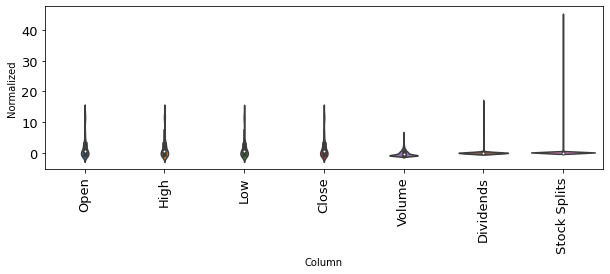

In [8]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(10, 3))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [9]:
import tensorflow as tf 

Init Plugin
Init Graph Optimizer
Init Kernel


In [10]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [11]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]

    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

#### plot

In [48]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
    inputs, labels = self.example

    plt.figure(figsize=(12, 6))
    plot_col_index = self.column_indices[plot_col]
    print(plot_col_index)
    
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)

        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

#        label_col_index = self.label_columns_indices.get(plot_col, None)
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)

        if model is not None:
            predictions = model(inputs)

            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=13)
            
        if n==1: 
            plt.ylabel(f'{plot_col} [normed]')

        plt.xlabel('Time [days]')

WindowGenerator.plot = plot

In [13]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [14]:

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    
    result = getattr(self, '_example', None)
    
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#### compile and fit 

In [43]:
MAX_EPOCHS = 400

def compile_and_fit(model, window, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

### single-step models

In [15]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [16]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Close']

In [17]:
baseline = Baseline(label_index=column_indices['Close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, 
                                            verbose=0)

Metal device set to: Apple M1


2021-08-26 12:26:52.541050: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-26 12:26:52.541178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-08-26 12:26:52.728839: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-26 12:26:52.729162: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11/19 [================>.............] - ETA: 0s - loss: 0.0178 - mean_absolute_error: 0.0852

2021-08-26 12:26:52.820343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 11ms/step - loss: 0.0190 - mean_absolute_error: 0.0870


#### linear 

In [19]:
linear = tf.keras.Sequential([
        tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/400
 4/64 [>.............................] - ETA: 1s - loss: 0.4358 - mean_absolute_error: 0.5146 

2021-08-26 12:26:59.477858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


62/64 [============================>.] - ETA: 0s - loss: 0.4263 - mean_absolute_error: 0.5050

2021-08-26 12:27:00.581055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 2s 20ms/step - loss: 0.4231 - mean_absolute_error: 0.5027 - val_loss: 4.7441 - val_mean_absolute_error: 1.9574
Epoch 2/400
64/64 [==============================] - 1s 20ms/step - loss: 0.2820 - mean_absolute_error: 0.4023 - val_loss: 2.6000 - val_mean_absolute_error: 1.4273
Epoch 3/400
64/64 [==============================] - 1s 18ms/step - loss: 0.2065 - mean_absolute_error: 0.3363 - val_loss: 1.5759 - val_mean_absolute_error: 1.0958
Epoch 4/400
64/64 [==============================] - 1s 20ms/step - loss: 0.1587 - mean_absolute_error: 0.2904 - val_loss: 1.0319 - val_mean_absolute_error: 0.8773
Epoch 5/400
64/64 [==============================] - 1s 20ms/step - loss: 0.1241 - mean_absolute_error: 0.2546 - val_loss: 0.7546 - val_mean_absolute_error: 0.7468
Epoch 6/400
64/64 [==============================] - 1s 17ms/step - loss: 0.0970 - mean_absolute_error: 0.2246 - val_loss: 0.5673 - val_mean_absolute_error: 0.6450
Epoch 7/400
64/64 [=========

In [20]:
wide_window = WindowGenerator(
    input_width=40, label_width=40, shift=1,
    label_columns=['Close'])

wide_window

Total window size: 41
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Label column name(s): ['Close']

3


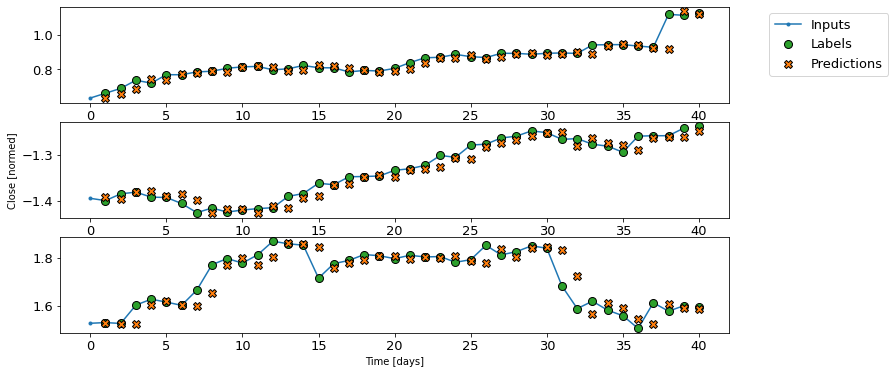

In [24]:
wide_window.plot(linear)

#### Dense

#### CNN

In [25]:
CONV_WIDTH = 3
label_width = 40
input_width = label_width + (CONV_WIDTH - 1)

conv_window = WindowGenerator(
    input_width=input_width,
    label_width=label_width,
    shift=1,
    label_columns=['Close'])

conv_window

Total window size: 43
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Label column name(s): ['Close']

In [26]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [27]:
history = compile_and_fit(conv_model, conv_window)

#IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/400
 5/63 [=>............................] - ETA: 0s - loss: 0.4191 - mean_absolute_error: 0.5005 

2021-08-26 12:29:58.673648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.0710 - mean_absolute_error: 0.1553

2021-08-26 12:30:00.187115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 28ms/step - loss: 0.0710 - mean_absolute_error: 0.1553 - val_loss: 0.0421 - val_mean_absolute_error: 0.1441
Epoch 2/400
63/63 [==============================] - 2s 31ms/step - loss: 0.0044 - mean_absolute_error: 0.0497 - val_loss: 0.0318 - val_mean_absolute_error: 0.1205
Epoch 3/400
63/63 [==============================] - 2s 30ms/step - loss: 0.0032 - mean_absolute_error: 0.0422 - val_loss: 0.0318 - val_mean_absolute_error: 0.1189
Epoch 4/400
63/63 [==============================] - 2s 32ms/step - loss: 0.0028 - mean_absolute_error: 0.0387 - val_loss: 0.0321 - val_mean_absolute_error: 0.1192
Epoch 5/400
63/63 [==============================] - 2s 31ms/step - loss: 0.0025 - mean_absolute_error: 0.0371 - val_loss: 0.0315 - val_mean_absolute_error: 0.1172
Epoch 6/400
63/63 [==============================] - 2s 29ms/step - loss: 0.0024 - mean_absolute_error: 0.0359 - val_loss: 0.0323 - val_mean_absolute_error: 0.1193
Epoch 7/400
63/63 [=========

3


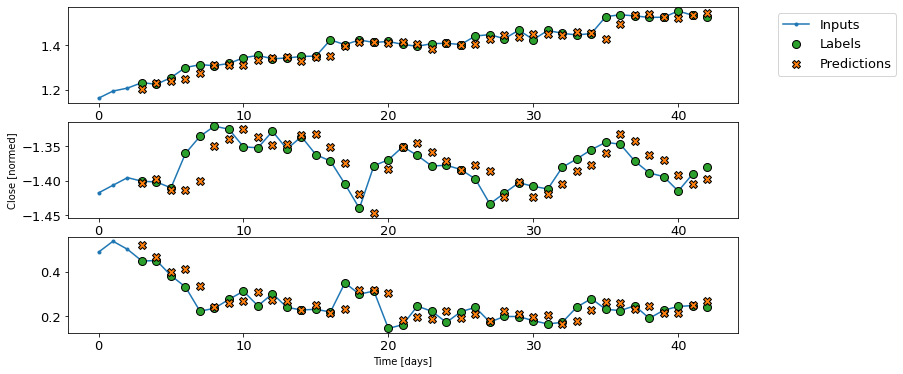

In [28]:
conv_window.plot(conv_model)

#### LSTM

In [29]:

lstm_window = WindowGenerator(
    input_width=40,
    label_width=40,
    shift=1,
    label_columns=['Close'])

lstm_window

Total window size: 41
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Label column name(s): ['Close']

In [30]:

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


history = compile_and_fit(lstm_model, lstm_window)


Epoch 1/400


2021-08-26 12:31:28.686335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-26 12:31:28.934446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-26 12:31:29.331434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.2597 - mean_absolute_error: 0.3433

2021-08-26 12:31:34.710972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-26 12:31:34.780062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 8s 100ms/step - loss: 0.2597 - mean_absolute_error: 0.3433 - val_loss: 3.6577 - val_mean_absolute_error: 1.5154
Epoch 2/400
63/63 [==============================] - 5s 76ms/step - loss: 0.0417 - mean_absolute_error: 0.1154 - val_loss: 2.7752 - val_mean_absolute_error: 1.2287
Epoch 3/400
63/63 [==============================] - 5s 73ms/step - loss: 0.0291 - mean_absolute_error: 0.0884 - val_loss: 2.5150 - val_mean_absolute_error: 1.1449
Epoch 4/400
63/63 [==============================] - 5s 75ms/step - loss: 0.0229 - mean_absolute_error: 0.0775 - val_loss: 2.3089 - val_mean_absolute_error: 1.0805
Epoch 5/400
63/63 [==============================] - 5s 75ms/step - loss: 0.0190 - mean_absolute_error: 0.0703 - val_loss: 2.1581 - val_mean_absolute_error: 1.0339
Epoch 6/400
63/63 [==============================] - 4s 70ms/step - loss: 0.0160 - mean_absolute_error: 0.0644 - val_loss: 2.0381 - val_mean_absolute_error: 0.9942
Epoch 7/400
63/63 [========

Epoch 51/400
63/63 [==============================] - 5s 72ms/step - loss: 0.0013 - mean_absolute_error: 0.0254 - val_loss: 0.4838 - val_mean_absolute_error: 0.4118
Epoch 52/400
63/63 [==============================] - 5s 76ms/step - loss: 0.0013 - mean_absolute_error: 0.0253 - val_loss: 0.4824 - val_mean_absolute_error: 0.4132
Epoch 53/400
63/63 [==============================] - 5s 76ms/step - loss: 0.0013 - mean_absolute_error: 0.0252 - val_loss: 0.4812 - val_mean_absolute_error: 0.4134
Epoch 54/400
63/63 [==============================] - 5s 77ms/step - loss: 0.0013 - mean_absolute_error: 0.0251 - val_loss: 0.4727 - val_mean_absolute_error: 0.4043
Epoch 55/400
63/63 [==============================] - 5s 76ms/step - loss: 0.0013 - mean_absolute_error: 0.0251 - val_loss: 0.4759 - val_mean_absolute_error: 0.4088
Epoch 56/400
63/63 [==============================] - 5s 74ms/step - loss: 0.0013 - mean_absolute_error: 0.0251 - val_loss: 0.4675 - val_mean_absolute_error: 0.4006
Epoch 57/4

3


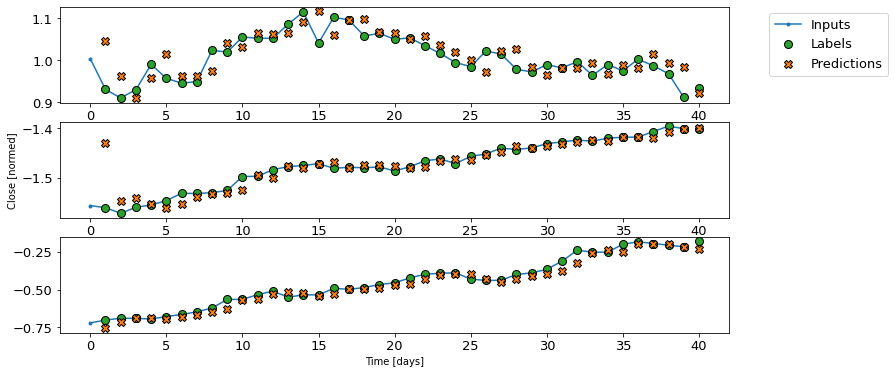

In [31]:
lstm_window.plot(lstm_model)

### multi-step models

3


Total window size: 64
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label indices: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Label column name(s): None

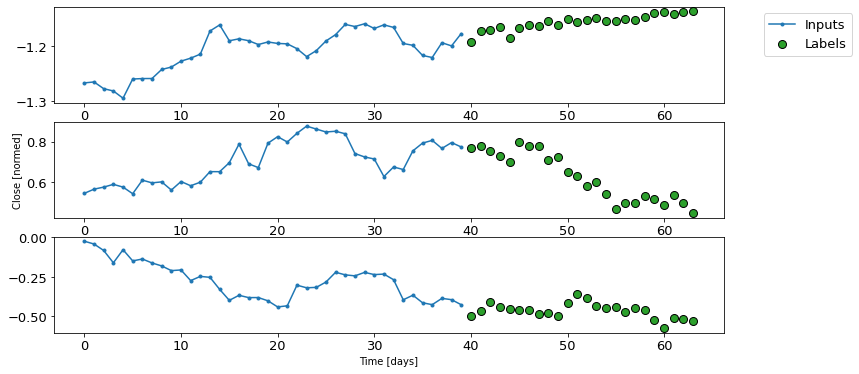

In [38]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=40,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

11/17 [==================>...........] - ETA: 0s - loss: 1.0529 - mean_absolute_error: 0.2862

2021-08-26 12:40:39.840946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 13ms/step - loss: 1.0466 - mean_absolute_error: 0.2824
3


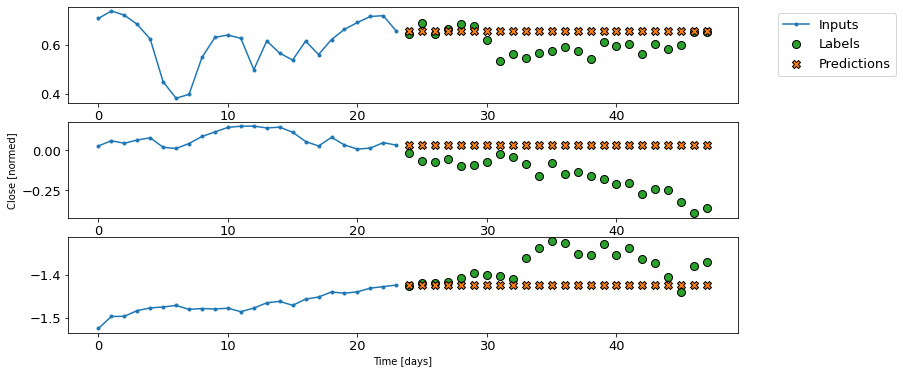

In [33]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

10/17 [================>.............] - ETA: 0s - loss: 1.1881 - mean_absolute_error: 0.4043

2021-08-26 12:40:40.865437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 13ms/step - loss: 1.1942 - mean_absolute_error: 0.4037
3


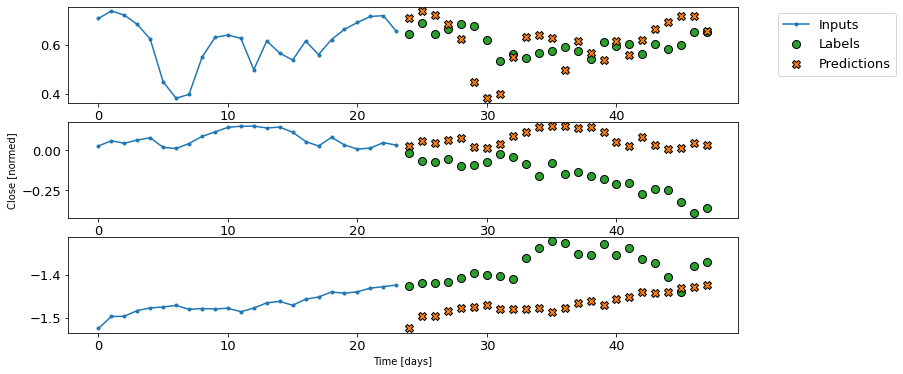

In [34]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

#### linear

Epoch 1/400
13/63 [=====>........................] - ETA: 0s - loss: 0.8580 - mean_absolute_error: 0.5810

2021-08-26 12:40:44.758194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


62/63 [============================>.] - ETA: 0s - loss: 0.8152 - mean_absolute_error: 0.5298

2021-08-26 12:40:45.788944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 20ms/step - loss: 0.8141 - mean_absolute_error: 0.5296 - val_loss: 5.3001 - val_mean_absolute_error: 1.6759
Epoch 2/400
63/63 [==============================] - 1s 22ms/step - loss: 0.5888 - mean_absolute_error: 0.3966 - val_loss: 3.1822 - val_mean_absolute_error: 1.3016
Epoch 3/400
63/63 [==============================] - 1s 19ms/step - loss: 0.4710 - mean_absolute_error: 0.3030 - val_loss: 2.0446 - val_mean_absolute_error: 1.0206
Epoch 4/400
63/63 [==============================] - 1s 17ms/step - loss: 0.4158 - mean_absolute_error: 0.2427 - val_loss: 1.4680 - val_mean_absolute_error: 0.8114
Epoch 5/400
63/63 [==============================] - 1s 18ms/step - loss: 0.3926 - mean_absolute_error: 0.2084 - val_loss: 1.1802 - val_mean_absolute_error: 0.6714
Epoch 6/400
63/63 [==============================] - 1s 20ms/step - loss: 0.3830 - mean_absolute_error: 0.1899 - val_loss: 1.0384 - val_mean_absolute_error: 0.5863
Epoch 7/400
63/63 [=========

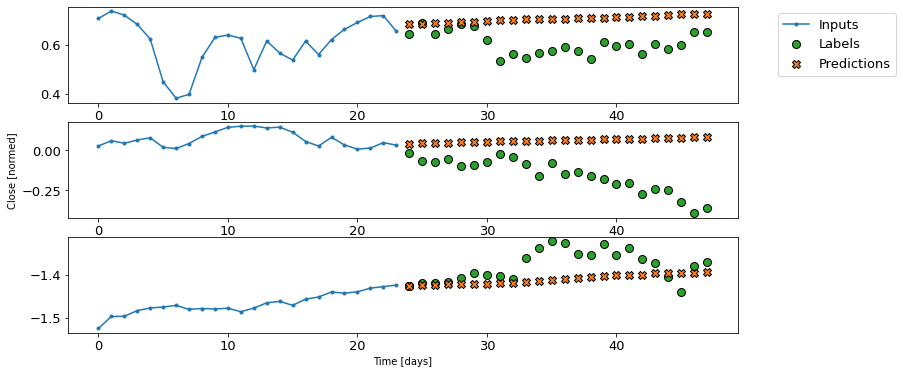

In [35]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

#IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### dense

Epoch 1/400
 3/63 [>.............................] - ETA: 1s - loss: 1.0120 - mean_absolute_error: 0.5796 

2021-08-26 12:41:43.608095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


62/63 [============================>.] - ETA: 0s - loss: 0.4676 - mean_absolute_error: 0.2570

2021-08-26 12:41:45.042388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 27ms/step - loss: 0.4672 - mean_absolute_error: 0.2568 - val_loss: 0.8533 - val_mean_absolute_error: 0.4635
Epoch 2/400
63/63 [==============================] - 1s 24ms/step - loss: 0.3710 - mean_absolute_error: 0.1586 - val_loss: 0.6884 - val_mean_absolute_error: 0.3600
Epoch 3/400
63/63 [==============================] - 2s 26ms/step - loss: 0.3703 - mean_absolute_error: 0.1558 - val_loss: 0.6744 - val_mean_absolute_error: 0.3611
Epoch 4/400
63/63 [==============================] - 1s 23ms/step - loss: 0.3703 - mean_absolute_error: 0.1563 - val_loss: 0.6661 - val_mean_absolute_error: 0.3357
Epoch 5/400
63/63 [==============================] - 2s 25ms/step - loss: 0.3697 - mean_absolute_error: 0.1565 - val_loss: 0.6552 - val_mean_absolute_error: 0.3332
Epoch 6/400
63/63 [==============================] - 2s 29ms/step - loss: 0.3684 - mean_absolute_error: 0.1546 - val_loss: 0.6578 - val_mean_absolute_error: 0.3318
Epoch 7/400
63/63 [=========

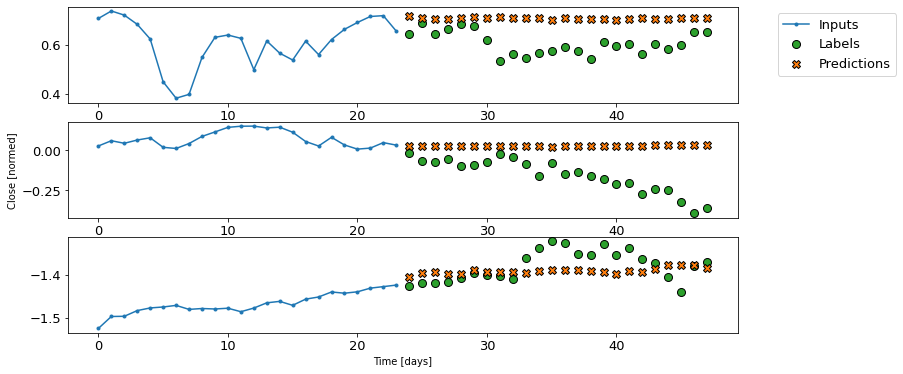

In [36]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

In [49]:
multi_window

Total window size: 64
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label indices: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Label column name(s): None

In [52]:
for i, j in multi_window.train.take(1):
    print(i)

tf.Tensor(
[[[-0.96952885 -0.9779114  -0.98087734 ...  0.35960042 -0.1032076
   -0.02216211]
  [-0.99022996 -0.9937591  -0.99304926 ... -0.35643315 -0.1032076
   -0.02216211]
  [-0.976871   -0.97493774 -0.96908134 ...  0.02179315 -0.1032076
   -0.02216211]
  ...
  [-0.78039706 -0.7902737  -0.7769979  ... -0.32763836 -0.1032076
   -0.02216211]
  [-0.789439   -0.8033506  -0.800111   ...  0.30060115 -0.1032076
   -0.02216211]
  [-0.80582315 -0.8001404  -0.79139227 ... -0.14472441 -0.1032076
   -0.02216211]]

 [[ 0.6200831   0.60361636  0.5659732  ... -0.6687025  -0.1032076
   -0.02216211]
  [ 0.5406083   0.5342661   0.48449126 ...  0.184387   -0.1032076
   -0.02216211]
  [ 0.498953    0.47964868  0.4783215  ... -0.6221891  -0.1032076
   -0.02216211]
  ...
  [ 0.16722463  0.17135552  0.1575957  ... -0.5811841  -0.1032076
   -0.02216211]
  [ 0.17750214  0.16573654  0.16845025 ... -0.74168646 -0.1032076
   -0.02216211]
  [ 0.19882764  0.22575791  0.20980012 ... -0.5979684  -0.1032076
   -0.0

Epoch 1/400
16/62 [======>.......................] - ETA: 0s - loss: 0.5814 - mean_absolute_error: 0.3937

2021-08-26 12:48:06.233070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 1s 9ms/step - loss: 0.4529 - mean_absolute_error: 0.2454 - val_loss: 0.9072 - val_mean_absolute_error: 0.4932
Epoch 2/400
 8/62 [==>...........................] - ETA: 0s - loss: 0.4572 - mean_absolute_error: 0.1624

2021-08-26 12:48:06.758060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 1s 9ms/step - loss: 0.3731 - mean_absolute_error: 0.1599 - val_loss: 0.7470 - val_mean_absolute_error: 0.3900
Epoch 3/400
62/62 [==============================] - 1s 8ms/step - loss: 0.3693 - mean_absolute_error: 0.1558 - val_loss: 0.6790 - val_mean_absolute_error: 0.3437
Epoch 4/400
62/62 [==============================] - 1s 8ms/step - loss: 0.3681 - mean_absolute_error: 0.1558 - val_loss: 0.6810 - val_mean_absolute_error: 0.3535
Epoch 5/400
62/62 [==============================] - 1s 8ms/step - loss: 0.3678 - mean_absolute_error: 0.1560 - val_loss: 0.6780 - val_mean_absolute_error: 0.3458
Epoch 6/400
62/62 [==============================] - 1s 8ms/step - loss: 0.3676 - mean_absolute_error: 0.1573 - val_loss: 0.6771 - val_mean_absolute_error: 0.3466
Epoch 7/400
62/62 [==============================] - 1s 9ms/step - loss: 0.3683 - mean_absolute_error: 0.1589 - val_loss: 0.7123 - val_mean_absolute_error: 0.3884
Epoch 8/400
62/62 [===============

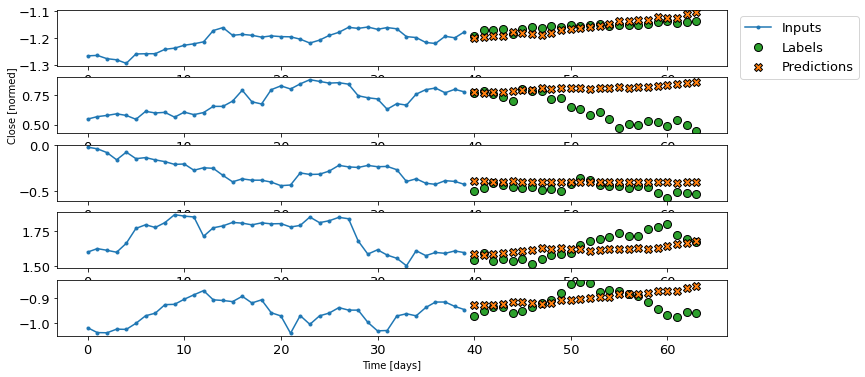

In [46]:
CONV_WIDTH = 3

from keras.layers.convolutional import MaxPooling1D


multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(512, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Flatten(),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

#IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

3
3
3
3
3
3


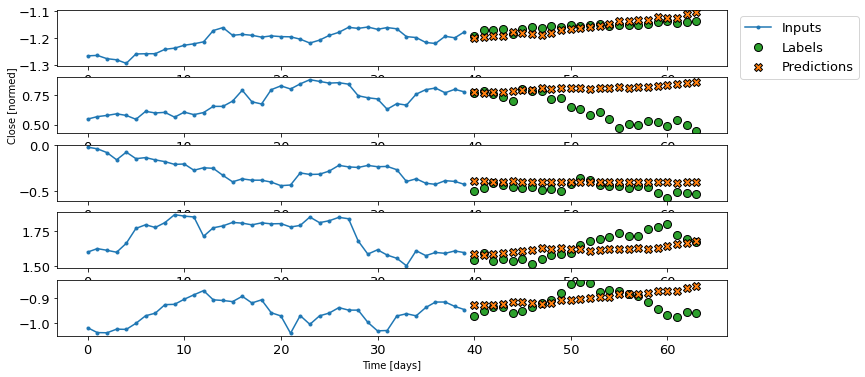

In [47]:
multi_window.plot(multi_conv_model, max_subplots=5)

#### LSTM